In [615]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import os
import re
import shutil
# import string
# import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem.porter import PorterStemmer
# from nltk.stem.snowball import SnowballStemmer
# from nltk.stem.wordnet import WordNetLemmatizer
# import re
import collections
import matplotlib.pyplot as plt
import numpy as np
# plt.style.use('ggplot')
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
from sklearn.decomposition import TruncatedSVD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [259]:
train_df=pd.read_csv('../data/processed_train.csv')

In [260]:
test_df=pd.read_csv('../data/processed_test.csv')

In [555]:
from list_to_corpus import *
from helper import *


In [ ]:
# test_df.info()

In [268]:
# %%time
# train_df['text']=train_df.text.fillna('uns_text')
# test_df['text']=test_df.text.fillna('uns_text')

CPU times: user 3.34 ms, sys: 264 µs, total: 3.6 ms
Wall time: 3.49 ms


In [ ]:
# train_df.head()

In [270]:
%%time
train_corpus=list_corpus(train_df['text'])
test_corpus=list_corpus(test_df['text'])

CPU times: user 19.7 s, sys: 208 ms, total: 19.9 s
Wall time: 21 s


In [327]:
len(train_corpus), len(test_corpus)

(7613, 3263)

In [271]:
word = [doc.split() for doc in test_corpus]
lst = []
for item in word:
    for i in item:
        lst.append(i)

In [272]:
len(collections.Counter(lst))

13166

In [273]:
train_target = train_df.pop('target')

In [275]:
# train_df

In [445]:
%%time
vectorizer = TfidfVectorizer(max_features=100)
train_tf_X = vectorizer.fit_transform(train_corpus)
test_tf_X = vectorizer.transform(test_corpus)

CPU times: user 302 ms, sys: 7.64 ms, total: 310 ms
Wall time: 318 ms


In [446]:
test_tf_X.shape, train_tf_X.shape

((3263, 100), (7613, 100))

## Embedding Model (only text features)

In [556]:
embedding_dim = 128
max_features = 399
embedding_model = embedding(embedding_dim, max_features)
embedding_model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_29 (Embedding)     (None, None, 128)         51200     
_________________________________________________________________
global_average_pooling1d_15  (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
Total params: 51,329
Trainable params: 51,329
Non-trainable params: 0
_________________________________________________________________


In [382]:
# history_dict = history.history
# history_dict.keys()

In [383]:
# fig, ax = plt.subplots(1,2,figsize=(15,4))

# acc = history_dict['binary_accuracy']
# val_acc = history_dict['val_binary_accuracy']
# loss = history_dict['loss']
# val_loss = history_dict['val_loss']

# epochs = range(1, len(acc) + 1)

# # "bo" is for "blue dot"
# ax[0].plot(epochs, loss, 'bo', label='Training loss')
# # b is for "solid blue line"
# ax[0].plot(epochs, val_loss, 'ro', label='Validation loss')
# ax[0].set_title('Training and validation loss (only text features)')
# ax[0].set_xlabel('Epochs')
# ax[0].set_ylabel('Loss')
# ax[0].legend()

# # "bo" is for "blue dot"
# ax[1].plot(epochs, acc, 'bo', label='Training accuracy')
# # b is for "solid blue line"
# ax[1].plot(epochs, val_acc, 'ro', label='Validation accuracy')
# ax[1].set_title('Training and validation accuracy (only text features)')
# ax[1].set_xlabel('Epochs')
# ax[1].set_ylabel('Accuracy')
# ax[1].legend()

# plt.tight_layout()


In [335]:
np.unique(model.predict(test_X))

array([-0.33723179, -0.33720806, -0.33720803], dtype=float32)

## Embedding model (all features)

In [205]:
test_df

,id,text,modified_keyword,modified_location,url_count,urls,emoji_count
0,1,Our Deeds are the Reason of this #earthquake M...,uns_keyword,uns_location,0,uns_url,0
1,4,Forest fire near La Ronge Sask. Canada,uns_keyword,uns_location,0,uns_url,0
2,5,All residents asked to 'shelter in place' are ...,uns_keyword,uns_location,0,uns_url,0
3,6,"13,000 people receive #wildfires evacuation or...",uns_keyword,uns_location,0,uns_url,0
4,7,Just got sent this photo from Ruby #Alaska as ...,uns_keyword,uns_location,0,uns_url,0
...,...,...,...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,uns_keyword,uns_location,0,uns_url,0
7609,10870,@aria_ahrary @TheTawniest The out of control w...,uns_keyword,uns_location,0,uns_url,0
7610,10871,M1.94 [0104 UTC]?5km S of Volcano Hawaii.,uns_keyword,uns_location,1,http//t.co/zDtoyd8EbJ,1
7611,10872,Police investigating after an e-bike collided ...,uns_keyword,uns_location,0,uns_url,0


In [406]:
vectorizer = CountVectorizer(max_features=100, binary=True)
train_dummy_keyword = vectorizer.fit_transform(list_corpus(train_df['modified_keyword'])).toarray()
test_dummy_keyword = vectorizer.transform(list_corpus(test_df['modified_keyword'])).toarray()

In [407]:
vectorizer = CountVectorizer(max_features=100, binary=True)
train_dummy_location = vectorizer.fit_transform(list_corpus(train_df['modified_location'])).toarray()
test_dummy_location = vectorizer.transform(list_corpus(test_df['modified_location'])).toarray()

In [408]:
vectorizer = CountVectorizer(max_features=100, binary=True)
train_dummy_urls = vectorizer.fit_transform(list_corpus(train_df['urls'])).toarray()
test_dummy_urls = vectorizer.transform(list_corpus(test_df['urls'])).toarray()

In [350]:
train_dummy_keyword.shape, test_dummy_keyword.shape

((7613, 100), (3263, 100))

In [448]:
train_X_augmented = np.hstack([train_tf_X.toarray(), train_dummy_location, train_dummy_keyword, train_dummy_urls])

In [449]:
test_X_augmented = np.hstack([test_tf_X.toarray(), test_dummy_location, test_dummy_keyword, test_dummy_urls])

In [520]:
train_X_augmented.shape, test_X_augmented.shape

((7613, 400), (3263, 400))

In [552]:
np.unique(train_target.values)

array([0, 1])

In [ ]:
from model import *
embedding_dim = 128
max_features = 399
embedding_model = embedding(embedding_dim, max_features)
embedding_model.summary()

In [565]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
history_augmented = embedding_model.fit(train_X_augmented, train_target.values, verbose=1, batch_size = 200, epochs = 1, validation_split=0.2,
                   shuffle=True, callbacks=[tensorboard_callback])

31/31 [==============================] - 109s 4s/step - loss: 0.6808 - ACCURACY: 0.5793 - val_loss: 0.6961 - val_ACCURACY: 0.5345


In [324]:
train_X_augmented.shape, test_X_augmented.shape

((7613, 15289), (3263, 13536))

In [566]:
np.unique(embedding_model.predict(test_X))

array([-0.34413534, -0.3441353 ], dtype=float32)

In [562]:
train_df

,id,text,modified_keyword,modified_location,url_count,urls,emoji_count
0,1,Our Deeds are the Reason of this #earthquake M...,uns_keyword,uns_location,0,uns_url,0
1,4,Forest fire near La Ronge Sask. Canada,uns_keyword,uns_location,0,uns_url,0
2,5,All residents asked to 'shelter in place' are ...,uns_keyword,uns_location,0,uns_url,0
3,6,"13,000 people receive #wildfires evacuation or...",uns_keyword,uns_location,0,uns_url,0
4,7,Just got sent this photo from Ruby #Alaska as ...,uns_keyword,uns_location,0,uns_url,0
...,...,...,...,...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,uns_keyword,uns_location,0,uns_url,0
7609,10870,@aria_ahrary @TheTawniest The out of control w...,uns_keyword,uns_location,0,uns_url,0
7610,10871,M1.94 [0104 UTC]?5km S of Volcano Hawaii.,uns_keyword,uns_location,1,http//t.co/zDtoyd8EbJ,1
7611,10872,Police investigating after an e-bike collided ...,uns_keyword,uns_location,0,uns_url,0


# Naive Bayes

In [618]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split

In [619]:
X_train, X_test, y_train, y_test = train_test_split(train_X_augmented, train_target, test_size=0.2, random_state=32)

In [620]:
clf = BernoulliNB()

In [621]:
clf.fit(X_train, y_train)

BernoulliNB()

In [622]:
y_pred=clf.predict(X_test)

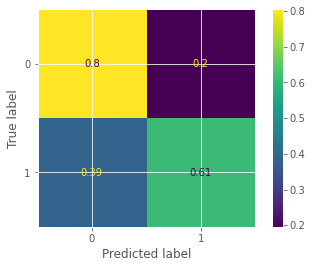

In [623]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test, normalize='true')
plt.show()

In [629]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
tn, fp, fn, tp  = confusion_matrix(y_test, prediction_).ravel()
f1_score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

In [632]:
f1_score

0.6457627118644067

# SVD

In [427]:
tSVD = TruncatedSVD(n_components=3)
data_3d = tSVD.fit_transform(train_X_augmented)

svd_df = pd.DataFrame()
svd_df['svd_one'] = data_3d[:, 0]
svd_df['svd_two'] = data_3d[:, 1]
svd_df['svd_three'] = data_3d[:, 2]

In [428]:
svd_df

,svd_one,svd_two,svd_three
0,1.672799,-0.012446,-0.498516
1,1.674047,-0.010724,-0.497911
2,1.670589,-0.012034,-0.500178
3,1.672441,-0.008768,-0.497656
4,1.673560,-0.011349,-0.499310
...,...,...,...
7608,1.673289,-0.010327,-0.498207
7609,1.674843,-0.008914,-0.496946
7610,1.187993,1.611329,-0.149652
7611,1.672050,-0.011546,-0.498921


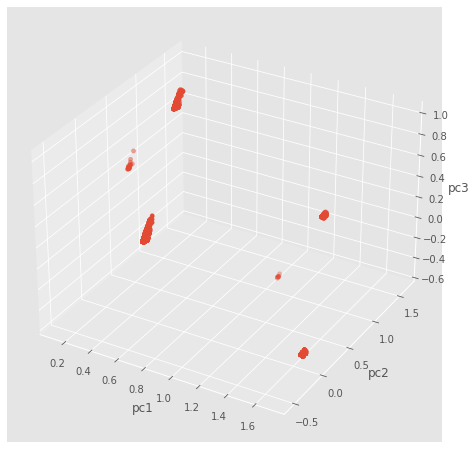

In [457]:
from matplotlib import cm
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(15,8))
ax = fig.gca(projection='3d')
ax.scatter(svd_df.svd_one, svd_df.svd_two, svd_df.svd_three, cmap=cm.coolwarm, linewidth=0.2)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')
plt.show()

## Random Forest

In [564]:
from sklearn.model_selection import train_test_split

In [587]:
X_train, X_test, y_train, y_test = train_test_split(train_X_augmented, train_target, test_size=0.2, random_state=32)

In [588]:
%%time
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=100, random_state=0)
clf.fit(X_train, y_train)

CPU times: user 4.89 s, sys: 149 ms, total: 5.04 s
Wall time: 6.25 s


RandomForestClassifier(max_depth=100, random_state=0)

In [589]:
prediction_=clf.predict(X_test)

In [624]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
tn, fp, fn, tp  = confusion_matrix(y_test, prediction_).ravel()
f1_score = f1_score(y_test, prediction_)
recall = recall_score(y_test, prediction_)
precision = precision_score(y_test, prediction_)

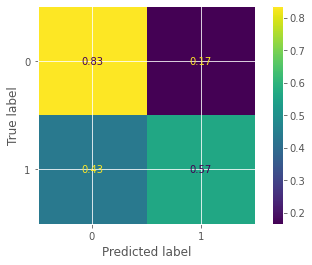

In [617]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_test, y_test, normalize='true')
plt.show()

# Gradient Boosting

In [634]:
from sklearn.ensemble import GradientBoostingClassifier

In [636]:
N_ESTIMATORS = 1000

model = GradientBoostingClassifier(learning_rate=0.01, 
                                   n_estimators=N_ESTIMATORS, 
                                   min_samples_leaf=10)
model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.01, min_samples_leaf=10,
                           n_estimators=1000)

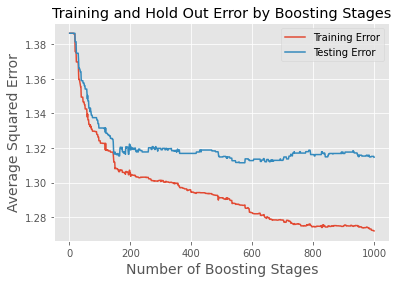

In [637]:
train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_train)):
    train_score[i] = model.loss_(y_train, y_pred)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Error")
plt.title("Training and Hold Out Error by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")

In [643]:
y_pred=model.predict(X_test)

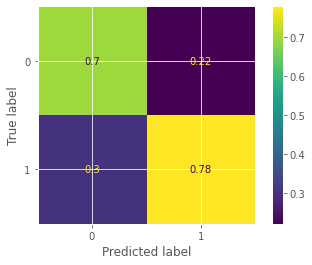

In [648]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(model, X_test, y_test, normalize='pred')
plt.show()

In [645]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
tn, fp, fn, tp  = confusion_matrix(y_test, prediction_).ravel()
f1_score = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

In [647]:
precision

0.7800586510263929